Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

Details about this solution are available [here](README.md#official-solution)

## Imports

In [8]:
from itertools import accumulate
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from icecream import ic

## Data

In [9]:
# Instances data
universe_sizes = [100, 1000, 10_000, 100_000, 100_000, 100_000]
num_sets_sizes = [10, 100, 1000, 10_000, 10_000, 10_000]
densities = [.2, .2, .2, .1, .2, .3]

# Density of True values in initial solution
INIT_DENSITY = 0.5

# Other useful constants
GREEDY_CFR = True
NUM_INSTANCES = len(universe_sizes)
MIN_INSTANCE = 1
MAX_INSTANCE = NUM_INSTANCES

## Generator function

In [10]:
def generate_data(universe_size, num_sets, density):
    SETS = np.random.random((num_sets, universe_size)) < density
    for s in range(universe_size):
        if not np.any(SETS[:, s]):
            SETS[np.random.randint(num_sets), s] = True
    COSTS = np.pow(SETS.sum(axis=1), 1.1)
    
    return SETS, COSTS

## Helper functions

In [11]:
def init_sol(num_sets: int) -> np.ndarray:
    solution = np.random.random(num_sets) < INIT_DENSITY
    
    return solution

def valid(sets, solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(sets[solution])     # at least each element covered by a set
    return np.all(phenotype)                             # all elements are covered

def coverage(sets, solution):
    """Returns the number of covered elements in the universe"""
    phenotype = np.logical_or.reduce(sets[solution])    # at least each element covered by a set
    return np.sum(phenotype)                            # number of covered elements    

def cost(costs, solution):
    """Returns the cost of a solution (to be minimized)"""
    return costs[solution].sum()

def fitness(covering: np.ndarray, costs: np.ndarray, solution: np.ndarray):
    """Returns the fitness of the given solution"""
    return (np.sum(covering > 0), -cost(costs, solution))

# Based on Vincenzo Avantaggiato's version
def tweak(solution: np.ndarray, covering: np.ndarray, sets: np.ndarray) -> np.ndarray:
    """Uses a single mutation method"""
    
    new_sol = solution.copy()
    
    index = np.random.randint(0, solution.shape[0])    
    new_sol[index] = not new_sol[index]
    
    modification = 2*new_sol[index]-1
    
    # Rollbacks the modification (if it is a removal): not allowed to remove a set from the solution
    # if its removal causes an element to become uncovered
    if modification == -1 and np.sum(covering[sets[index]] <= 1):
        return solution
        
    # Store the number of sets covering each element in the universe
    covering += modification * sets[index]
    
    return new_sol

## Solver function

In [12]:
def solve_set_cover(sets: np.ndarray, costs: np.ndarray, num_steps: int = 10_000, buf_size: int = 5, init_strength: float = 0.5):
    
    num_sets = sets.shape[0]
    universe_size = sets.shape[1]
    
    solution = init_sol(num_sets)
    best_cov = np.sum(sets[solution], axis=0)
    sol_fitness = fitness(best_cov, costs, solution)
    history = [float(sol_fitness[1])]
    
    # Initially, first valid index is 0 if starting solution is valid , otherwise it is -1
    first_valid = int(sol_fitness[0] == universe_size) - 1
    for i in tqdm(range(num_steps)):
        curr_cov = best_cov.copy()
        current = tweak(solution.copy(), curr_cov, sets)
        
        curr_fitness = fitness(curr_cov, costs, current)
        history.append(float(curr_fitness[1]))
        
        # Mark current index as first valid (index 0 is the initial solution)
        first_valid = i+1 if curr_fitness[0] == universe_size and first_valid == -1 else first_valid
        
        if curr_fitness > sol_fitness:
            sol_fitness = curr_fitness
            solution = current
            best_cov = curr_cov
            
    ic(first_valid)
    steps_sol = history.index(float(sol_fitness[1]))
    
    ic(sol_fitness)
    ic(steps_sol)
    
    plt.figure(figsize=(14,8))
    plt.plot(
        range(first_valid),
        list(np.full(first_valid, history[first_valid])),
        color="red",
        linestyle="--"
    )
    plt.plot(
        range(first_valid, len(history)),
        list(accumulate(history[first_valid :], max)),
        color="red",
    )
    plt.scatter(range(len(history)), history, marker=".", color="blue")
    
    return solution, sol_fitness, steps_sol
    

## Greedy optimization
For each iteration, we collect the set that covers the larger number of still uncovered elements. The iterations continue until complete universe coverage is reached.

In [13]:
def solve_greedy(sets: np.ndarray, costs: np.ndarray, num_sets) -> np.ndarray:
    
    solution = np.full(num_sets, False)
    set_matrix = sets.copy()
    covered = 0

    while covered < set_matrix.shape[1]:
        
        largest_index = np.argmax(set_matrix.sum(axis=1))
        largest = set_matrix[largest_index, :]
        solution[largest_index] = True
        covered += largest.sum()
        
        # For each row of the matrix, set to False the corresponding column if the cell of the "largest" vector is True
        # Given the vector corresponding to the coverings for the larger set (to collect),
        # it removes all possible coverings for those elements covered by this set,
        # in order to ignore them in next steps
        set_matrix *= np.logical_not(largest)
    
    sol_fitness = fitness(np.sum(sets[solution], axis=0), costs, solution)
    
    return solution, sol_fitness

## Solver caller

ic| instance_msg: 'Instance 1'


  0%|          | 0/1000 [00:00<?, ?it/s]

ic| first_valid: 18
ic| sol_fitness: (np.int64(100), np.float64(-280.69985830089905))
ic| steps_sol: 20
ic| sol_state: np.int64(100)
    sol_fitness: np.float64(-280.69985830089905)
ic| greedy_state: np.int64(100)
    greedy_fitness: np.float64(-280.69985830089905)
ic| instance_msg: 'Instance 2'


  0%|          | 0/1000 [00:00<?, ?it/s]

ic| first_valid: 0
ic| sol_fitness: (np.int64(1000), np.float64(-7877.119696252716))
ic| steps_sol: 115
ic| sol_state: np.int64(1000)
    sol_fitness: np.float64(-7877.119696252716)
ic| greedy_state: np.int64(1000)
    greedy_fitness: np.float64(-6070.924701997821)
ic| instance_msg: 'Instance 3'


  0%|          | 0/10000 [00:00<?, ?it/s]

ic| first_valid: 0
ic| sol_fitness: (np.int64(10000), np.float64(-127624.79711095142))
ic| steps_sol: 4899
ic| sol_state: np.int64(10000)
    sol_fitness: np.float64(-127624.79711095142)
ic| greedy_state: np.int64(10000)
    greedy_fitness: np.float64(-100385.86553148976)
ic| instance_msg: 'Instance 4'


  0%|          | 0/100000 [00:00<?, ?it/s]

ic| first_valid: 0
ic| sol_fitness: (np.int64(100000), np.float64(-1939231.0211132378))
ic| steps_sol: 51355
ic| sol_state: np.int64(100000)
    sol_fitness: np.float64(-1939231.0211132378)
ic| greedy_state: np.int64(100000)
    greedy_fitness: np.float64(-1520626.810680374)
ic| instance_msg: 'Instance 5'


  0%|          | 0/100000 [00:00<?, ?it/s]

ic| first_valid: 0
ic| sol_fitness: (np.int64(100000), np.float64(-2155944.2910249243))
ic| steps_sol: 59199
ic| sol_state: np.int64(100000)
    sol_fitness: np.float64(-2155944.2910249243)
ic| greedy_state: np.int64(100000)
    greedy_fitness: np.float64(-1730831.0402739164)
ic| instance_msg: 'Instance 6'


  0%|          | 0/100000 [00:00<?, ?it/s]

ic| first_valid: 0
ic| sol_fitness: (np.int64(100000), np.float64(-2184591.558418671))
ic| steps_sol: 62586
ic| sol_state: np.int64(100000)
    sol_fitness: np.float64(-2184591.558418671)
ic| greedy_state: np.int64(100000)
    greedy_fitness: np.float64(-1774346.3401856327)


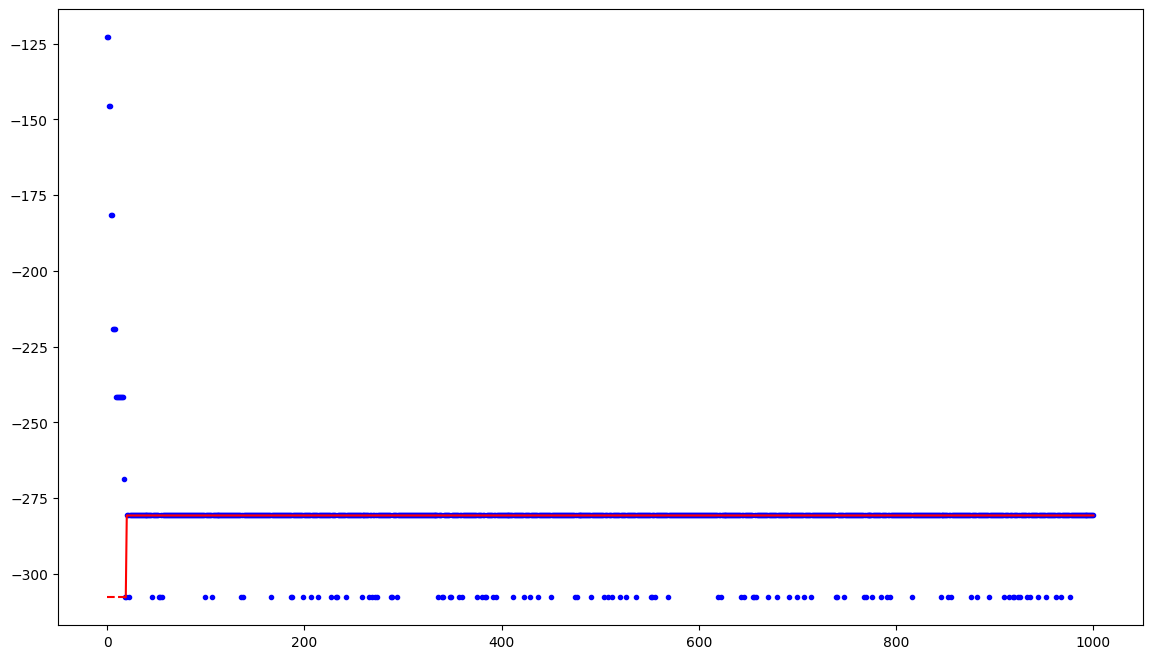

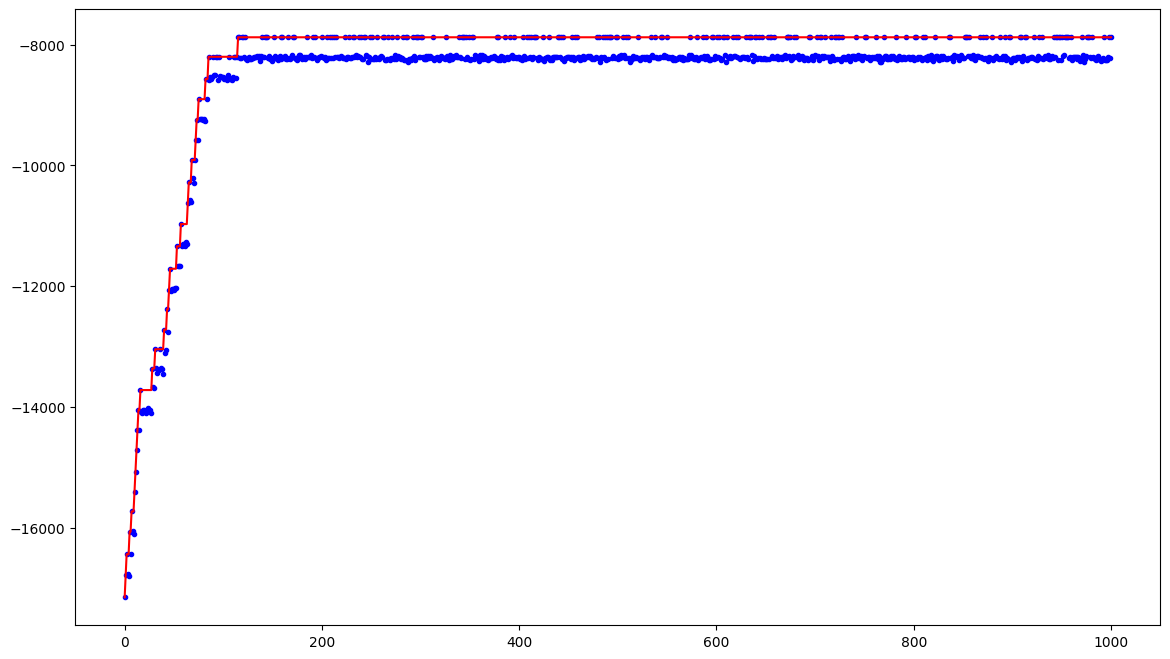

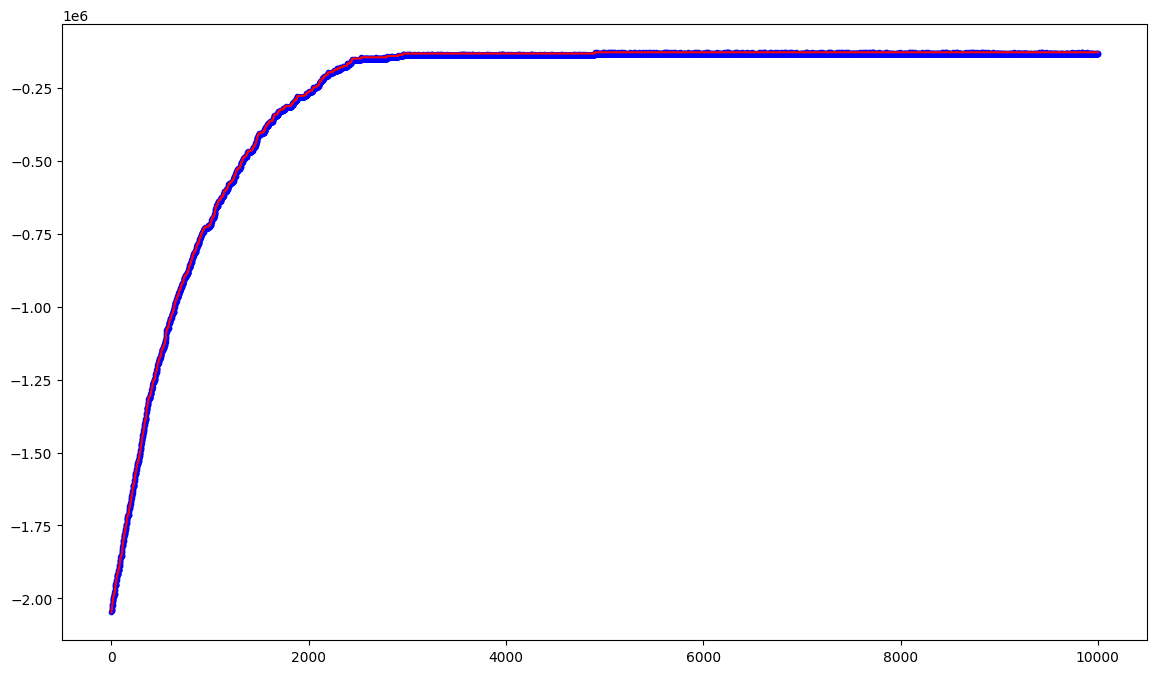

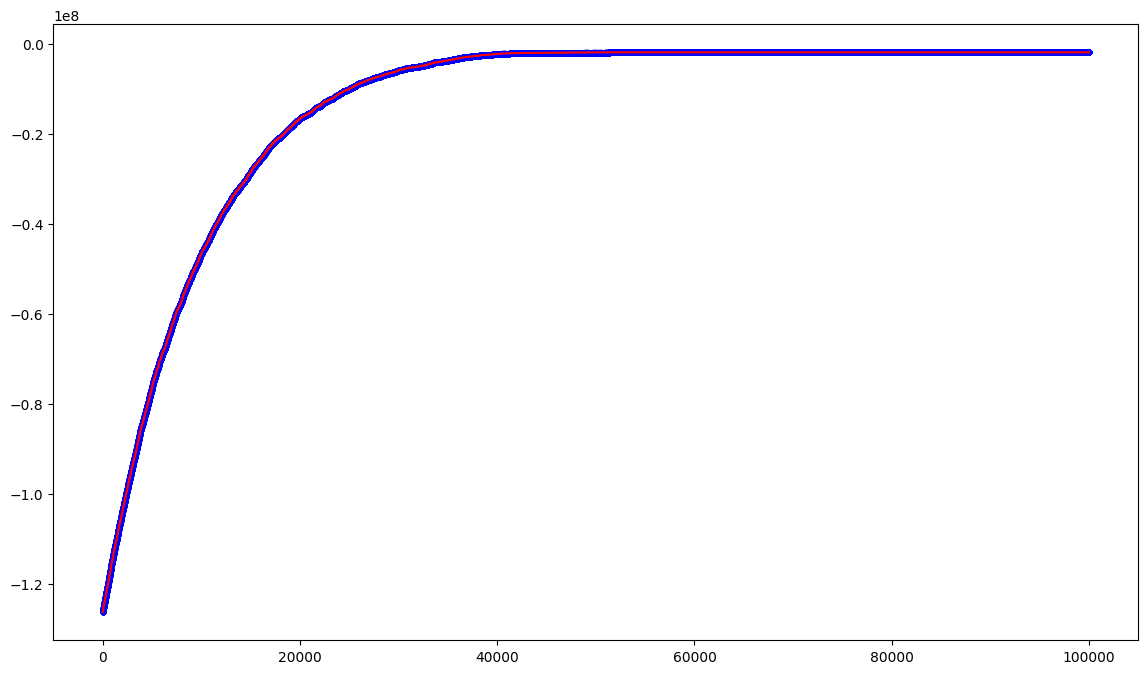

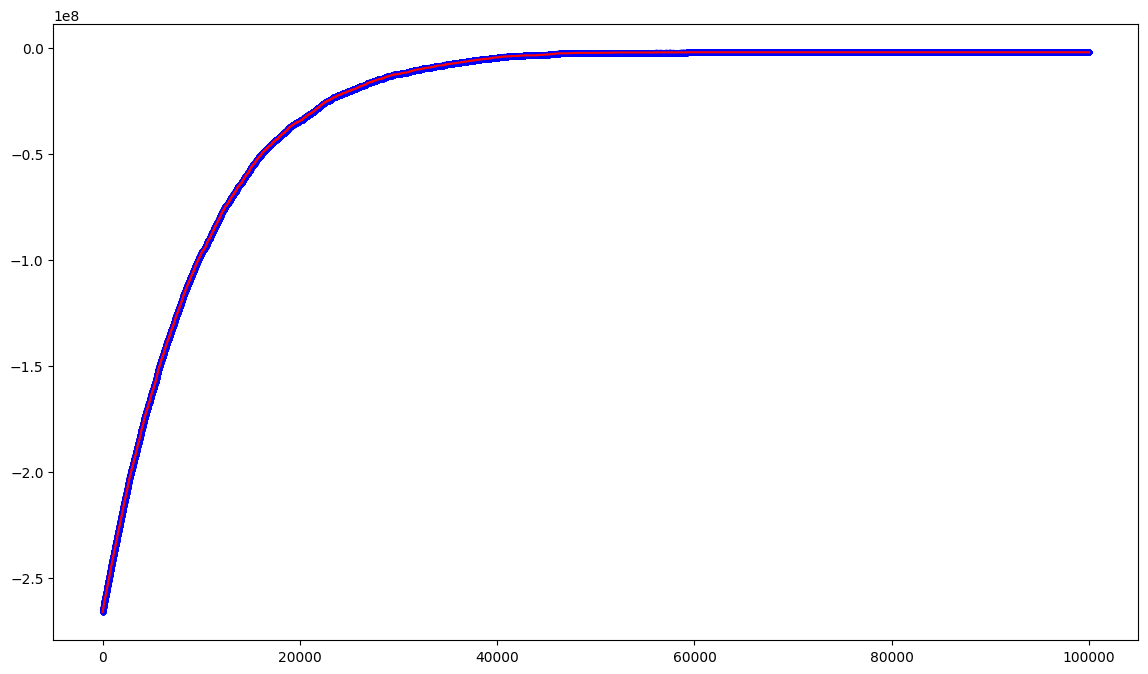

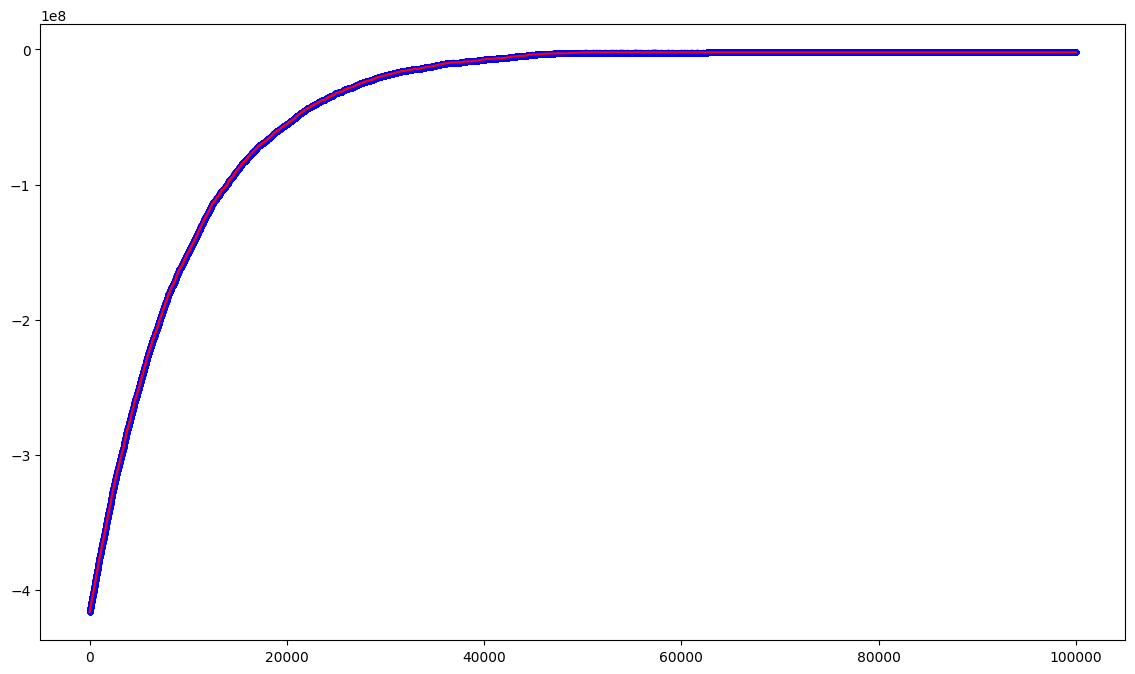

In [14]:

# Calls solver function (and greedy optimization, if requested) once for each instance
for (i, (universe_size, num_sets, density)) in \
    list(enumerate(zip(universe_sizes, num_sets_sizes, densities))) [MIN_INSTANCE-1 : MAX_INSTANCE]:

    instance_msg = f"Instance {i + 1}"
    
    ic(instance_msg)

    sets, costs = generate_data(universe_size, num_sets, density)
    
    num_steps = 100_000 if i > 2 else (10_000 if i == 2 else 1000)
    
    solution, (sol_state, sol_fitness), sol_steps = solve_set_cover(sets, costs, num_steps=num_steps)
    
    if GREEDY_CFR:
        greedy_sol, (greedy_state, greedy_fitness) = solve_greedy(sets, costs, num_sets)
    
    ic(sol_state, sol_fitness)
    
    if GREEDY_CFR:
        ic(greedy_state, greedy_fitness)
    